In [16]:
#import statements
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib import colorbar
import matplotlib.transforms as transforms
#import cmocean
import cartopy
import cartopy.util as util
import cartopy.crs as ccrs
import cartopy.feature as cfeature  # features such as the ocean, coastlines rivers, etc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import os #Double check in a bit for the timeseries, average file

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [2]:
import numpy as np
import xarray as xr

def pop_add_cyclic(ds):
    
    nj = ds.TLAT.shape[0] # size of POP grid
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data
#    print('Here')    
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon) #make monotoncially increasing
    lon  = np.concatenate((tlon, tlon + 360.), 1) # concatenate to make larger array
    lon = lon[:, xL:xR] #restrict to middle rane
#    print('Here')   
    if ni == 320: # this is the x1 POP grid
        print('\n')
       # lon[367:-3, 0] = lon[367:-3, 0] + 360.        #####TUPLE PROBLEM IS HERE
      #  print('Here')
    lon = lon - 360.
    
    lon = np.hstack((lon, lon[:, 0:1] + 360.)) # add in cyclic point

    if ni == 320:
        print('\n')
        #lon[367:, -1] = lon[367:, -1] - 360.  #####TUPLE PROBLEM IS HERE
        
    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    
   # lon[:, 0] = lon[:, 0] - 1e-8    ######TUPLE PROBLEM IS HERE
   
    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
    
    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})
    
    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)       
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), 
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})
                
            
    return dso

In [3]:
path = '/glade/u/home/chsharri/Work/NW/'
data = xr.open_dataset(path+'nw_ur_150_07.pop.h.TEMP.nc')

In [4]:
data

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 360, z_t: 60)
Coordinates:
  * time        (time) object 0005-02-01 00:00:00 ... 0035-01-01 00:00:00
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG       (nlat, nlon) float64 ...
    TLAT        (nlat, nlon) float64 ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object ...
    TEMP        (time, z_t, nlat, nlon) float32 ...
Attributes:
    title:                     nw_ur_150_07
    history:                   Fri Mar 20 14:28:29 2020: ncrcat -v TEMP /pl/a...
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    contents:                  Diagnostic and Prognostic Variables
    source:                    CCSM POP2, the CCSM Ocean Component
    revision:                  $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy...
    calendar:                  All years have exactly  365 days.
    start_time:                This dataset was created on 2018-06-25 at 01:1...
    cell_methods:              cell_methods = time: mean ==> the variable val...
    nsteps_total:              750
    tavg_sum:                  2592000.0
    tavg_sum_qflux:            2592000.0
    NCO:                       "4.6.0"
    nco_openmp_thread_number:  1

In [5]:
data_cyclic = pop_add_cyclic(data) # Remove seam

In [6]:
data_cyclic

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 321, time: 360, z_t: 60)
Coordinates:
  * time        (time) object 0005-02-01 00:00:00 ... 0035-01-01 00:00:00
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
    TLONG       (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.57 320.1
    time_bound  (time, d2) object 0005-01-02 01:00:00 ... 0035-01-01 00:00:00
    TEMP        (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan

In [7]:
x = data_cyclic['TLONG']
y = data_cyclic['TLAT']
plot = np.mean(data_cyclic.TEMP,axis=0)

### Plot data to make sure it looks good

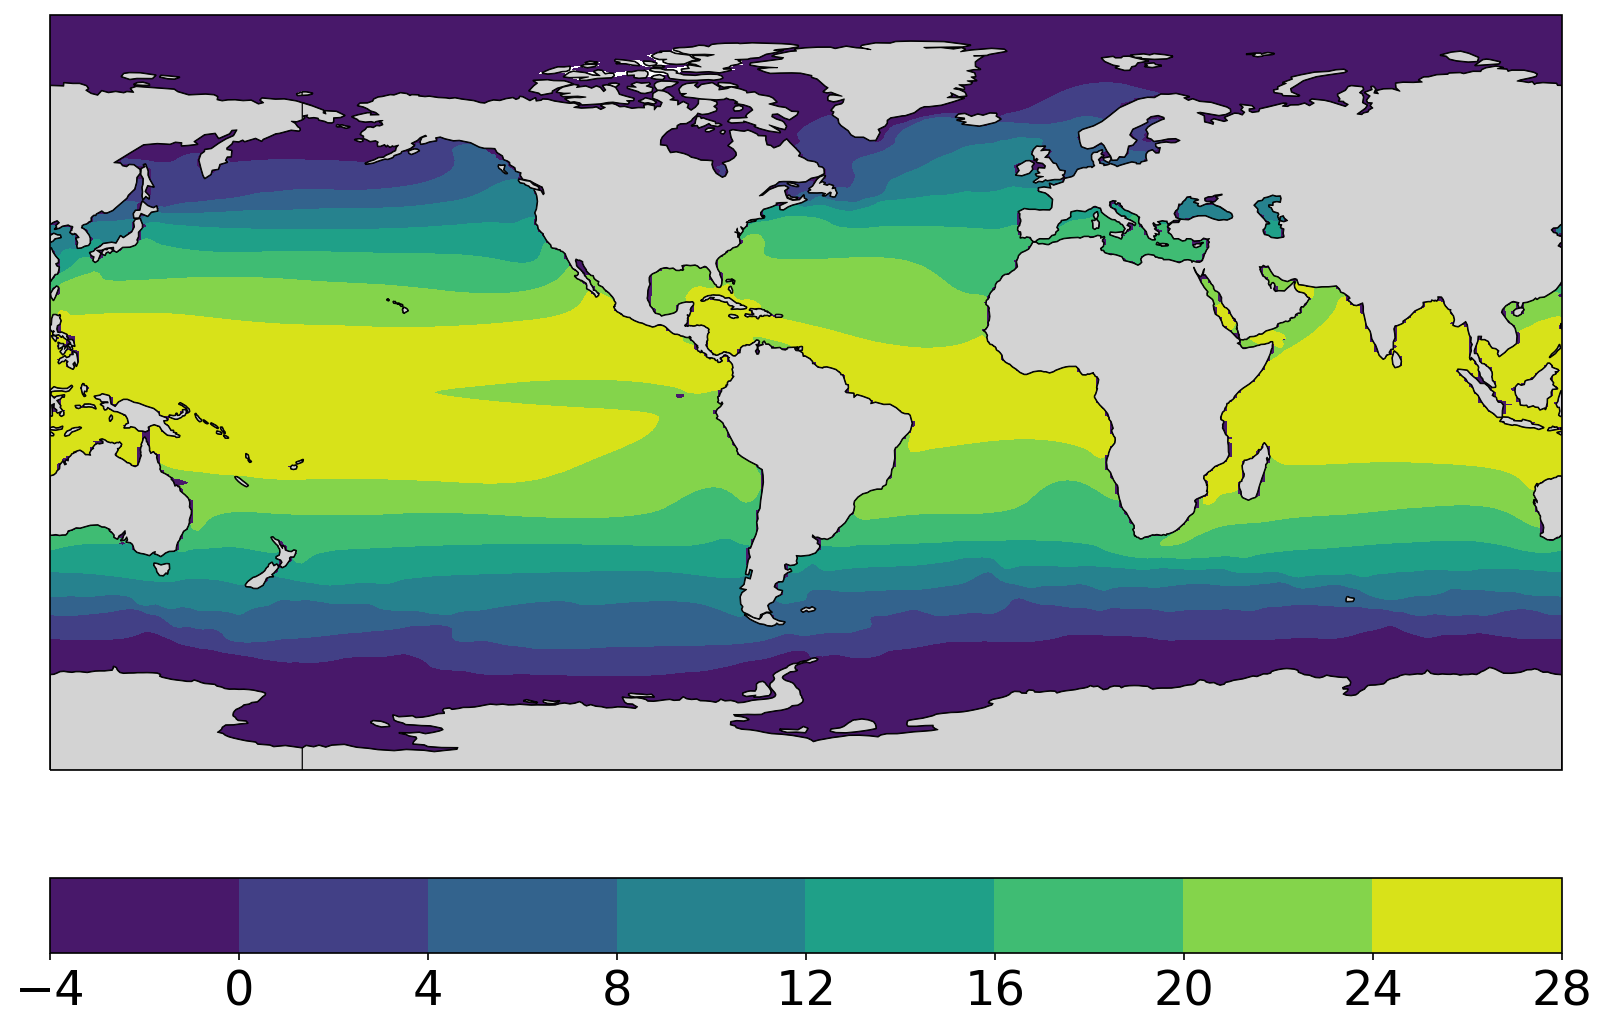

In [93]:


levels = np.arange(-30,32.5,2.5)
#levels = np.arange(-20,22,2)
#cmap = cmap.reversed()
#norm = BoundaryNorm(levels, ncolors=cmap.N, clip= False)

fig,ax= plt.subplots(figsize =(13,19),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-60)))
#plt.subplots_adjust( wspace=.05)   
#ax.set_global()
ax.set_extent([0,180,-90,90])
ax.add_feature(cfeature.LAND, color = 'lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.set_global()  

#x,y = temp_150.TLONG, temp_150.TLAT
p = ax.contourf(x, y,
                  plot, transform=ccrs.PlateCarree())
t = np.arange(-30,32.5,5)

cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
cbar.ax.tick_params(labelsize=23)
#cbar.set_label('Max $\Delta$SST' + ' ($^o$C) ', size = 30)
    
    
#ptitle = 'Maximum Monthly Sea Surface Temperature - 150 Tg'
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '110m', linewidth=0.5,edgecolor='black', facecolor='lightgray'))    


plt.show() 
plt.close()

## Plot onto updated projection

Even though this text is written on two separate lines,
it is parsed as a single paragraph.

This paragraph is separated from the previous paragraph
by a blank line.

#### Things to mess arounfd with if plot seems off: 

* width_ratios=[4,0.221] - resizing the second plot can help alighn them
* wspace=-0.075 - changing the width size can bring the two plots closer or farther
* ax2.set_extent([-239.9,-220,-90,90],crs=ccrs.PlateCarree() ) - change where the second projection is focusing on

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  if __name__ == '__main__':


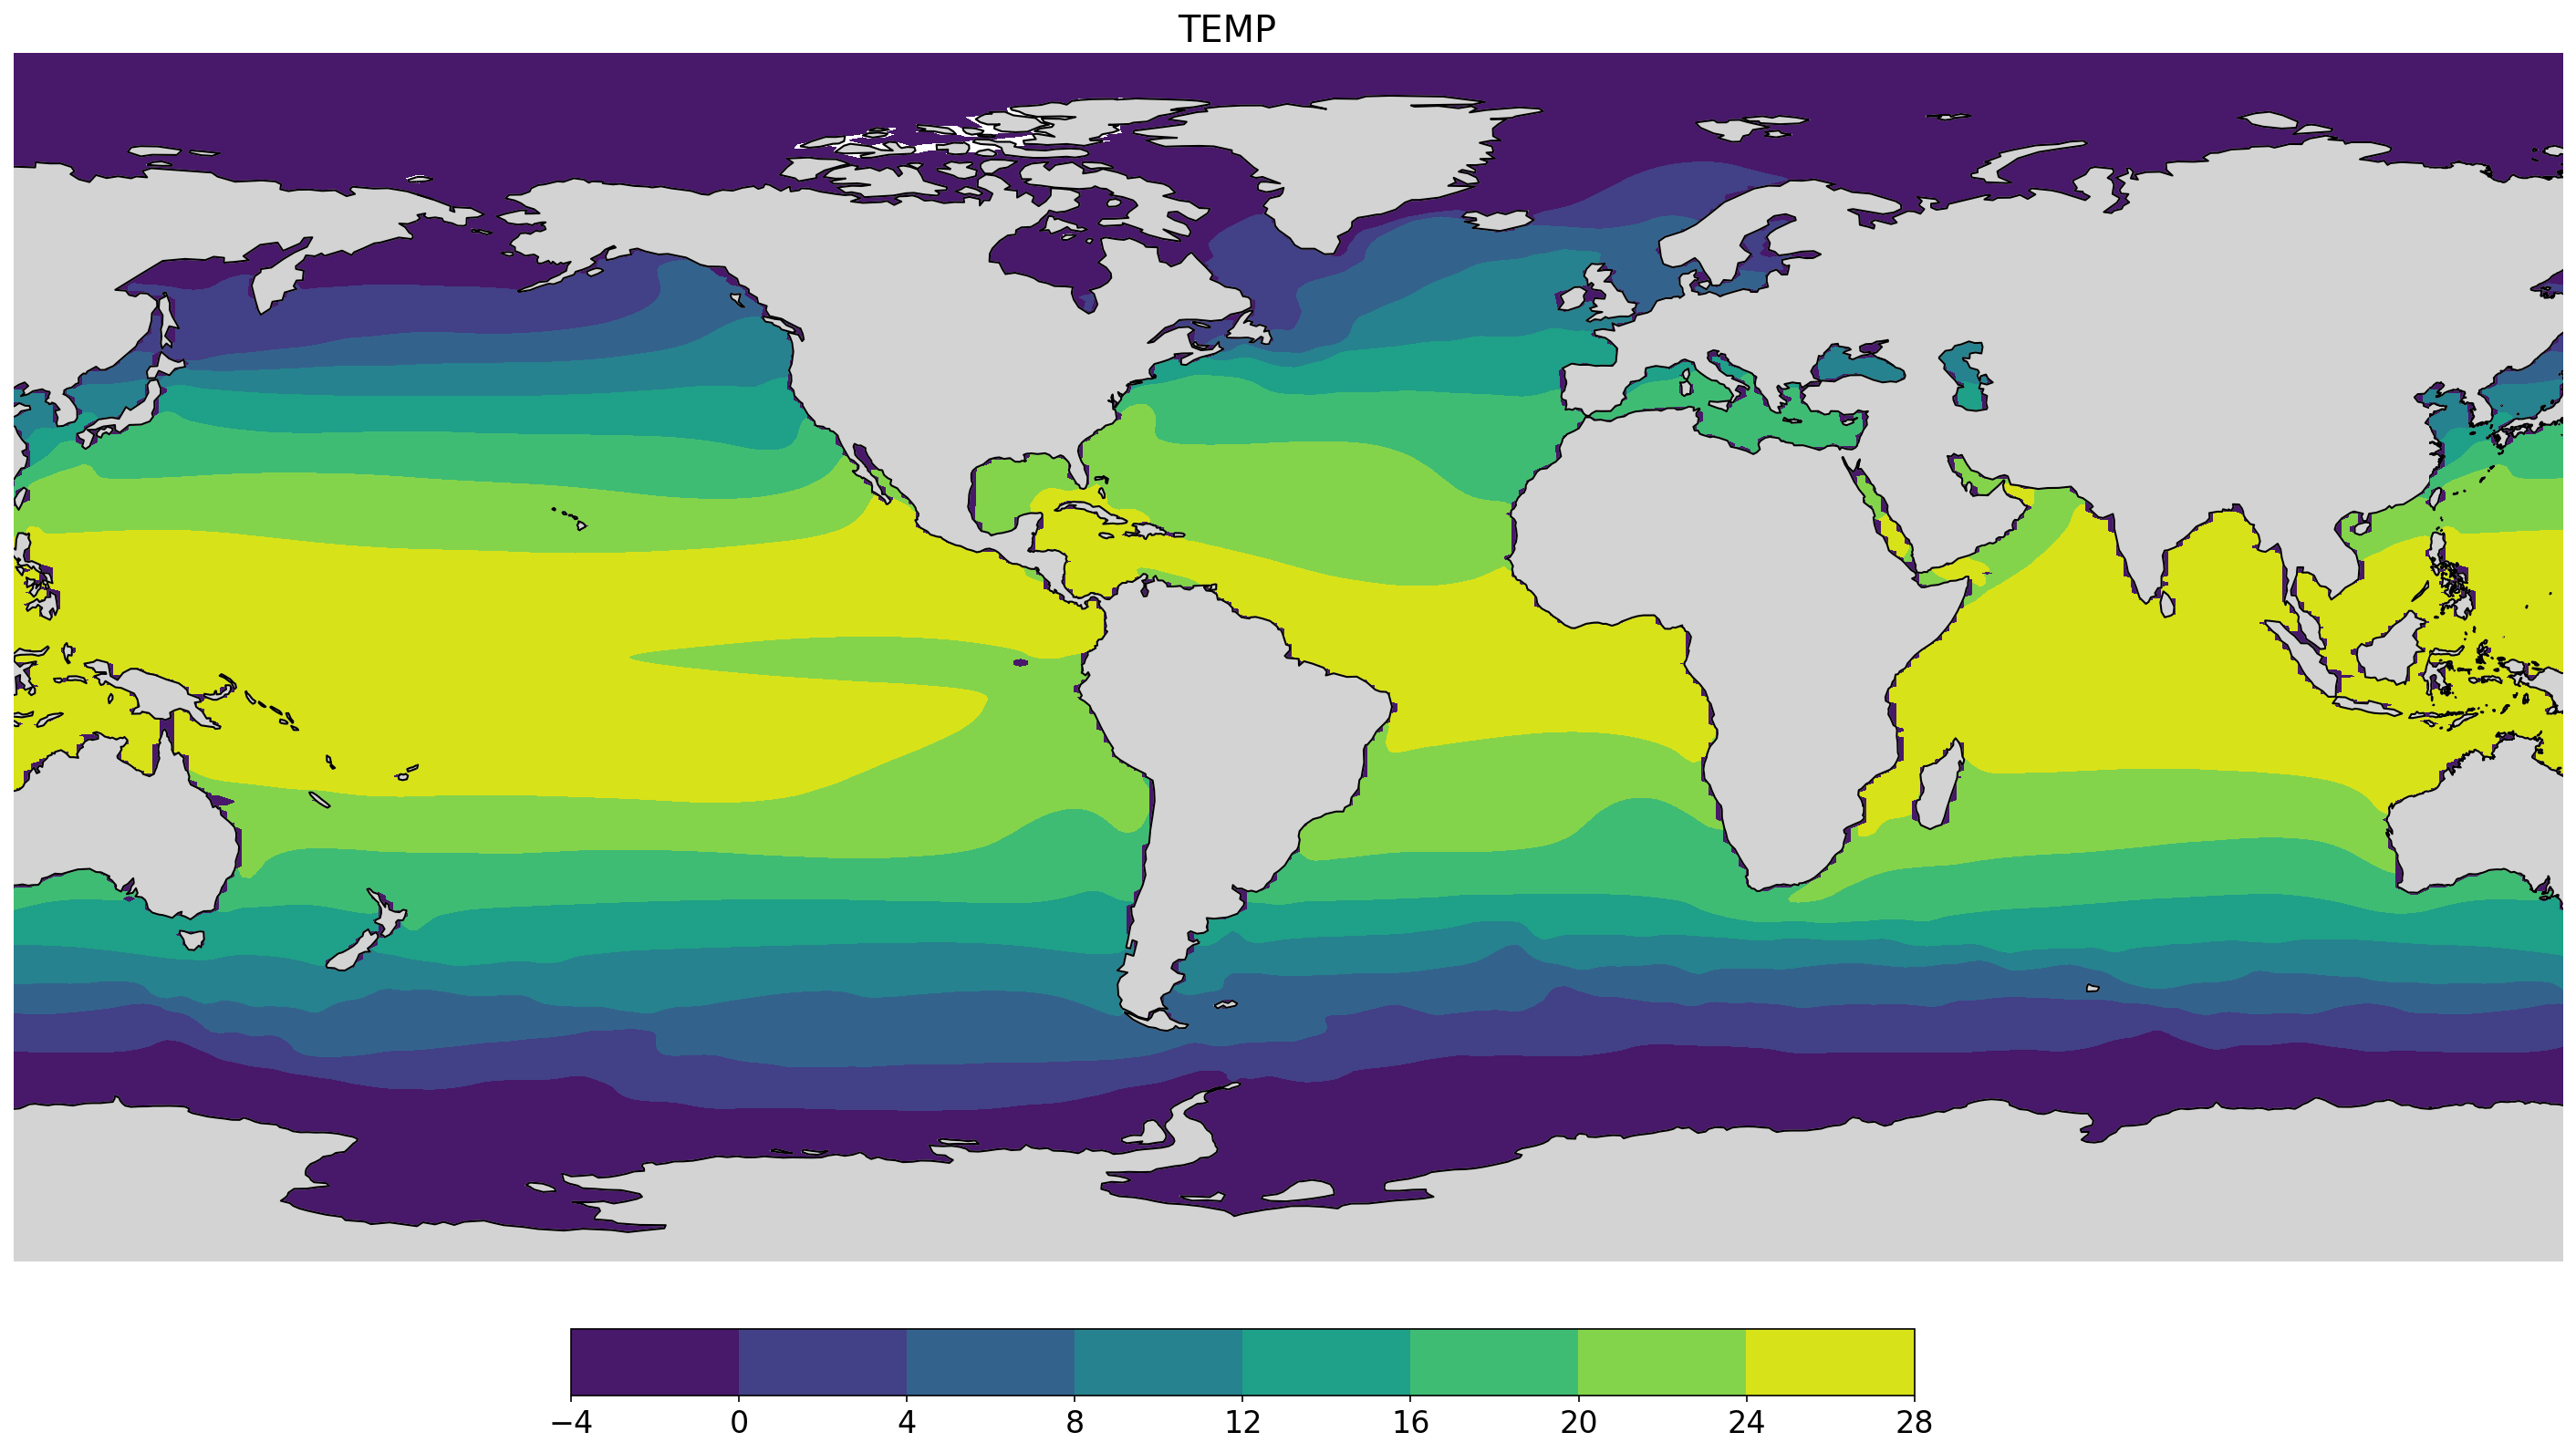

In [90]:
fig = plt.figure(figsize =(25,13),facecolor='white')
gs  = fig.add_gridspec(1,2,width_ratios=[4,0.221],height_ratios = [1], hspace=0.2,wspace=-0.075)

ax1=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=-60))
ax2=fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=-60))

axList=[ax1,ax2]
ax1.outline_patch.set_edgecolor('#FF000000')
ax2.outline_patch.set_edgecolor('#FF000000')

ax1.set_global()
ax2.set_extent([-239.9,-220,-90,90],crs=ccrs.PlateCarree() )






p1 = ax1.contourf(x,y,plot,transform=ccrs.PlateCarree())
p1 =ax2.contourf(x,y,plot,transform=ccrs.PlateCarree())


ax1.add_feature(cfeature.LAND, color = 'lightgray',zorder = 2) # add the land feature to the plot as a light gray color
ax1.add_feature(cfeature.COASTLINE,zorder = 2) # add the black coastline around the land
ax2.add_feature(cfeature.LAND, color = 'lightgray',zorder = 2) # add the land feature to the plot as a light gray color
ax2.add_feature(cfeature.COASTLINE,zorder = 2) # add the black coastline around the land


plt.colorbar(p1,ax=axList,orientation = 'horizontal',pad=0.05, fraction=0.05)
plt.title('TEMP', x=-9)
plt.show()
#cbar = plt.colorbar(p1,orientation='horizontal',x=0)